In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import neighbors
import graphviz
from sklearn import tree
from get_code import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import sys

In [2]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 15
%config InlineBackend.figure_format = 'retina'

In [3]:
path = "./Data2Learn/"
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths

In [4]:
dfn_list = []
for file in all_files:
    #print('Adding file %s'%file)
    # Getting the file name without extension
    file_name = os.path.splitext(os.path.basename(file))[0]
    # Reading the file content to create a DataFrame
    dfn = pd.read_csv(file)
    # Setting the file name (without extension) as the index name
    dfn.index.name = file_name
    # Append file
    dfn_list.append( dfn )
dfn = pd.concat(dfn_list)

In [5]:
dfn = dfn.query("Co<9 & Ro<9") #remove "reference"

In [6]:
dfn.head()

,Time,UNIX_T,RSSI1,RSSI2,RSSI3,Lux,Acc_x,Acc_y,Acc_z,Temp,ID,Pos,Si,Co,Ro
0,2017-09-20 13:20:57.351,1505906457351,56,75,47,63,-1106,-20,102,2048,1,223,2,2,3
1,2017-09-20 13:20:57.402,1505906457402,43,53,63,70,-1038,10,89,2025,2,253,2,5,3
2,2017-09-20 13:20:57.453,1505906457453,53,59,64,93,-1090,-47,135,1951,3,241,2,4,1
3,2017-09-20 13:20:57.503,1505906457503,51,66,64,162,-1074,5,109,1995,4,132,1,3,2
4,2017-09-20 13:20:57.555,1505906457555,51,64,60,82,-1051,-46,110,28431,5,231,2,3,1


In [7]:
feature_dict = {"Si":["Lux","RSSI1","RSSI2","RSSI3"], 
                "Ro":["RSSI1","RSSI2","RSSI3","Acc_x"], #Acc_x: vertical acceleration (gravity)
                "Co":["RSSI1","RSSI2","RSSI3"]}

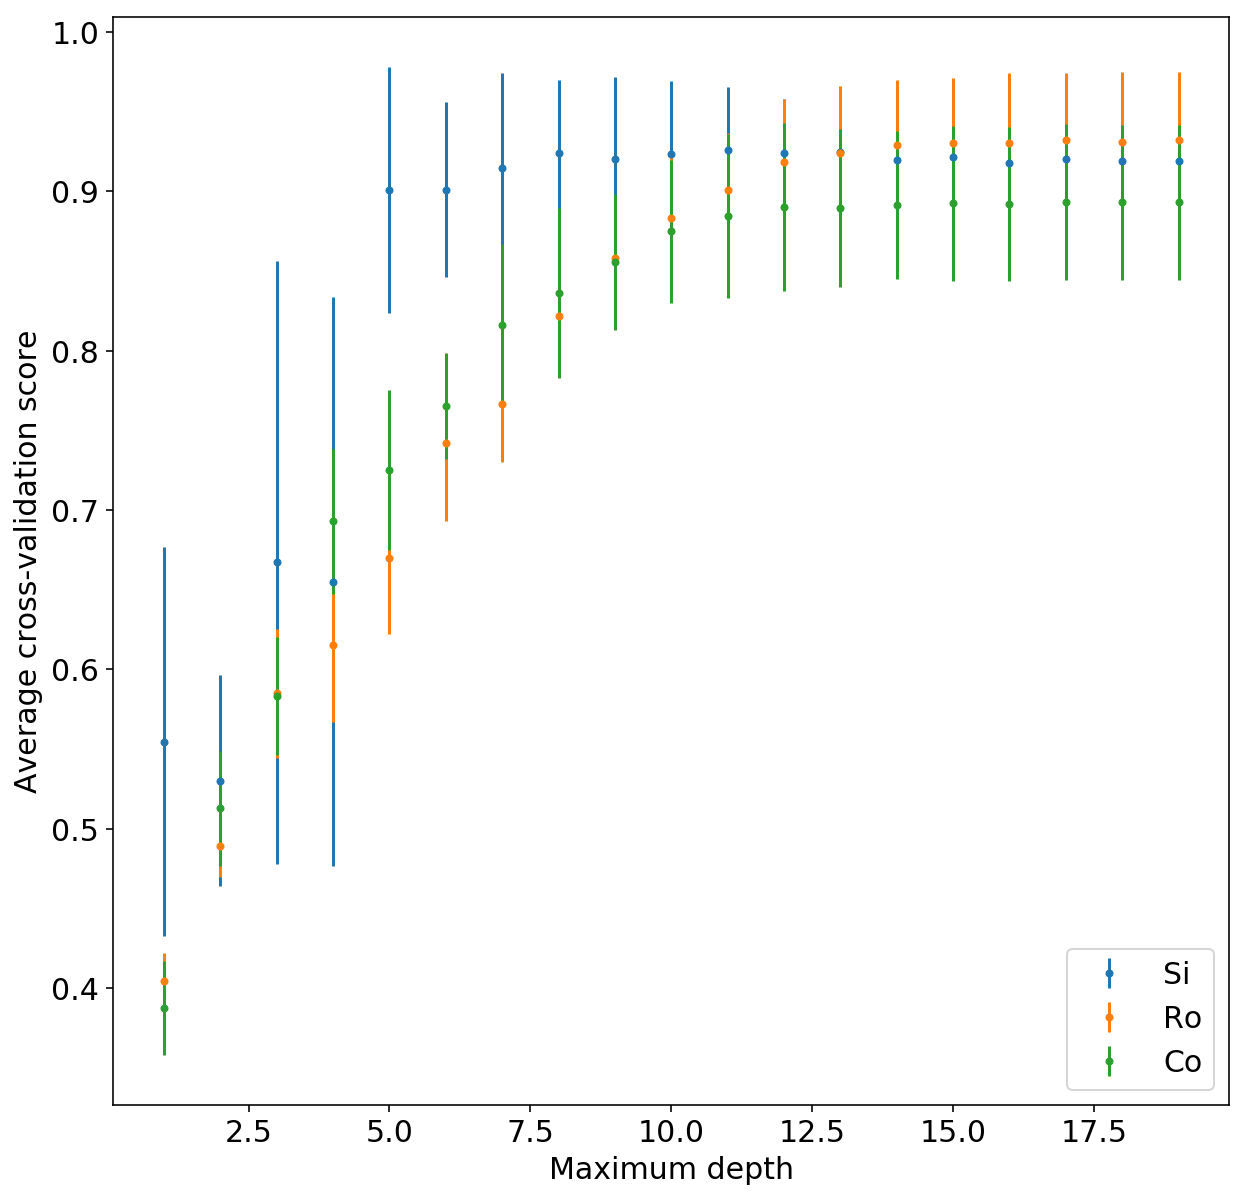

In [8]:
fig = plt.figure()
for i, target in enumerate(feature_dict.keys()):
    
    #Get train/test data
    features = feature_dict[target]
    
    X = dfn[features]
    y = dfn[target]
    
    X.astype(int)
    y.astype(int)
    
    depths = np.arange(1,20)
    mean_list = []
    std_list = []
    for mdepth in range(1,20):
        #clf = tree.DecisionTreeClassifier(max_depth=mdepth, min_samples_split=0.01, min_samples_leaf=0.01, random_state=42)
        clf = tree.DecisionTreeClassifier(max_depth=mdepth, random_state=42)
        scores = cross_val_score(clf, X, y, cv=10)
        mean_list.append( np.mean(scores) )
        std_list.append( np.std(scores) )
    
    mean = np.array(mean_list)
    std = np.array(std_list)
    plt.errorbar(depths, mean, std, None, '.', label=target)
    
plt.legend(loc='lower right')
plt.xlabel('Maximum depth')
plt.ylabel('Average cross-validation score')
plt.show()
fig.savefig("cross-validation.pdf")

In [9]:
depth_dict={"Si":5, "Ro":7, "Co":7}

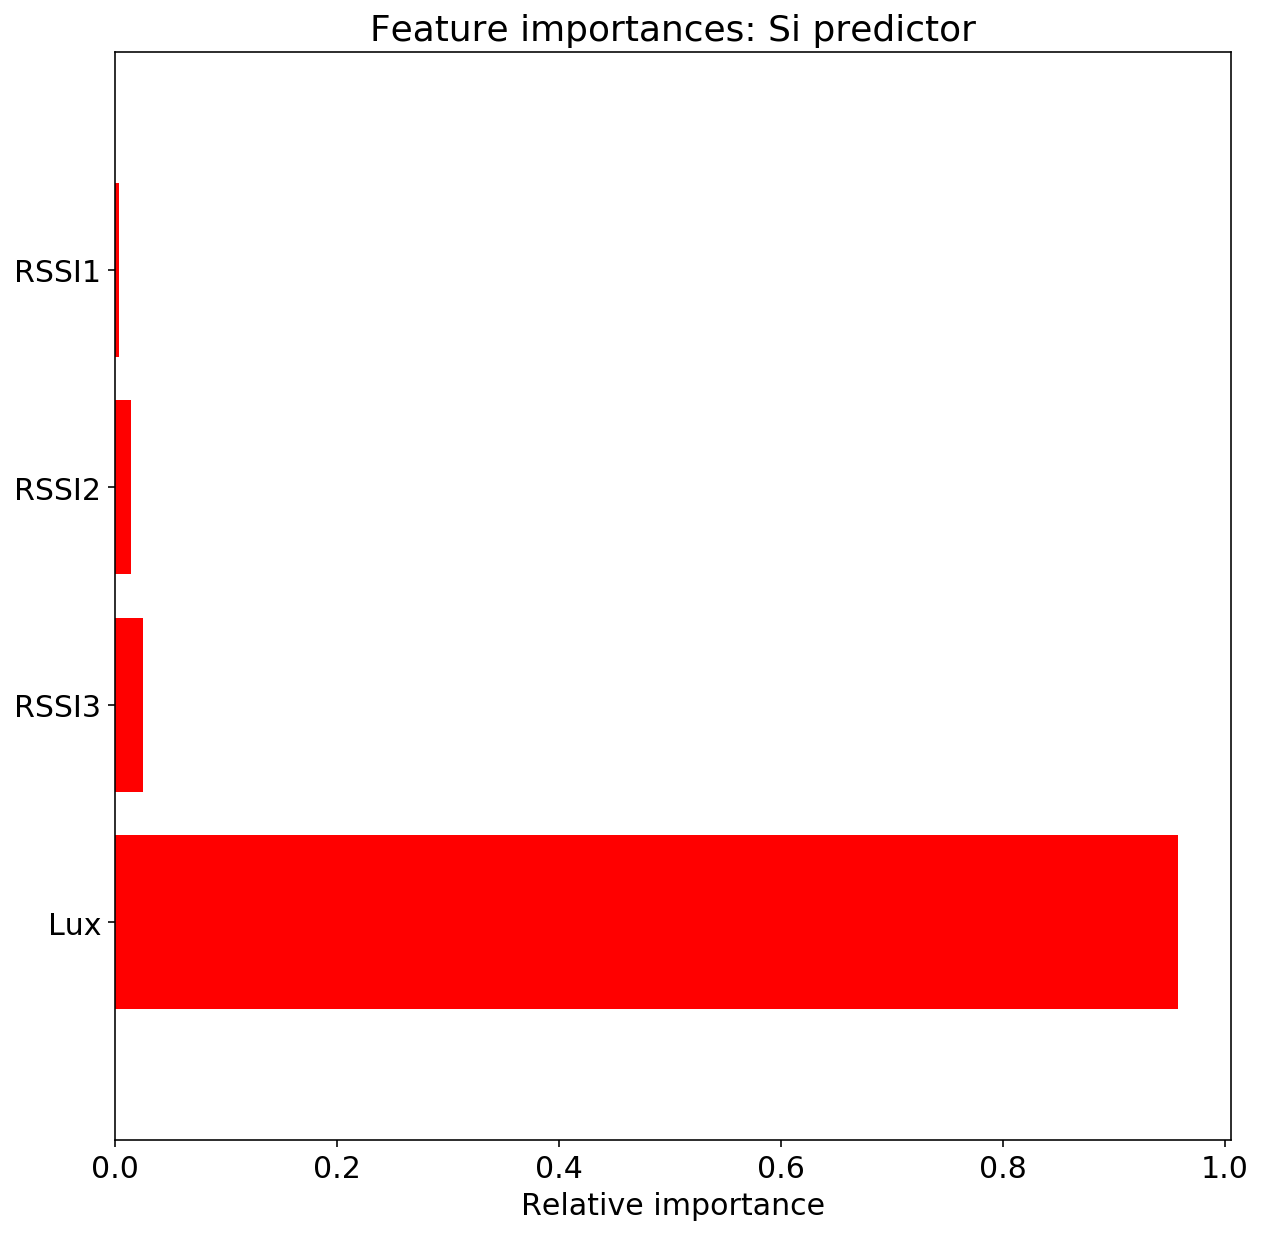

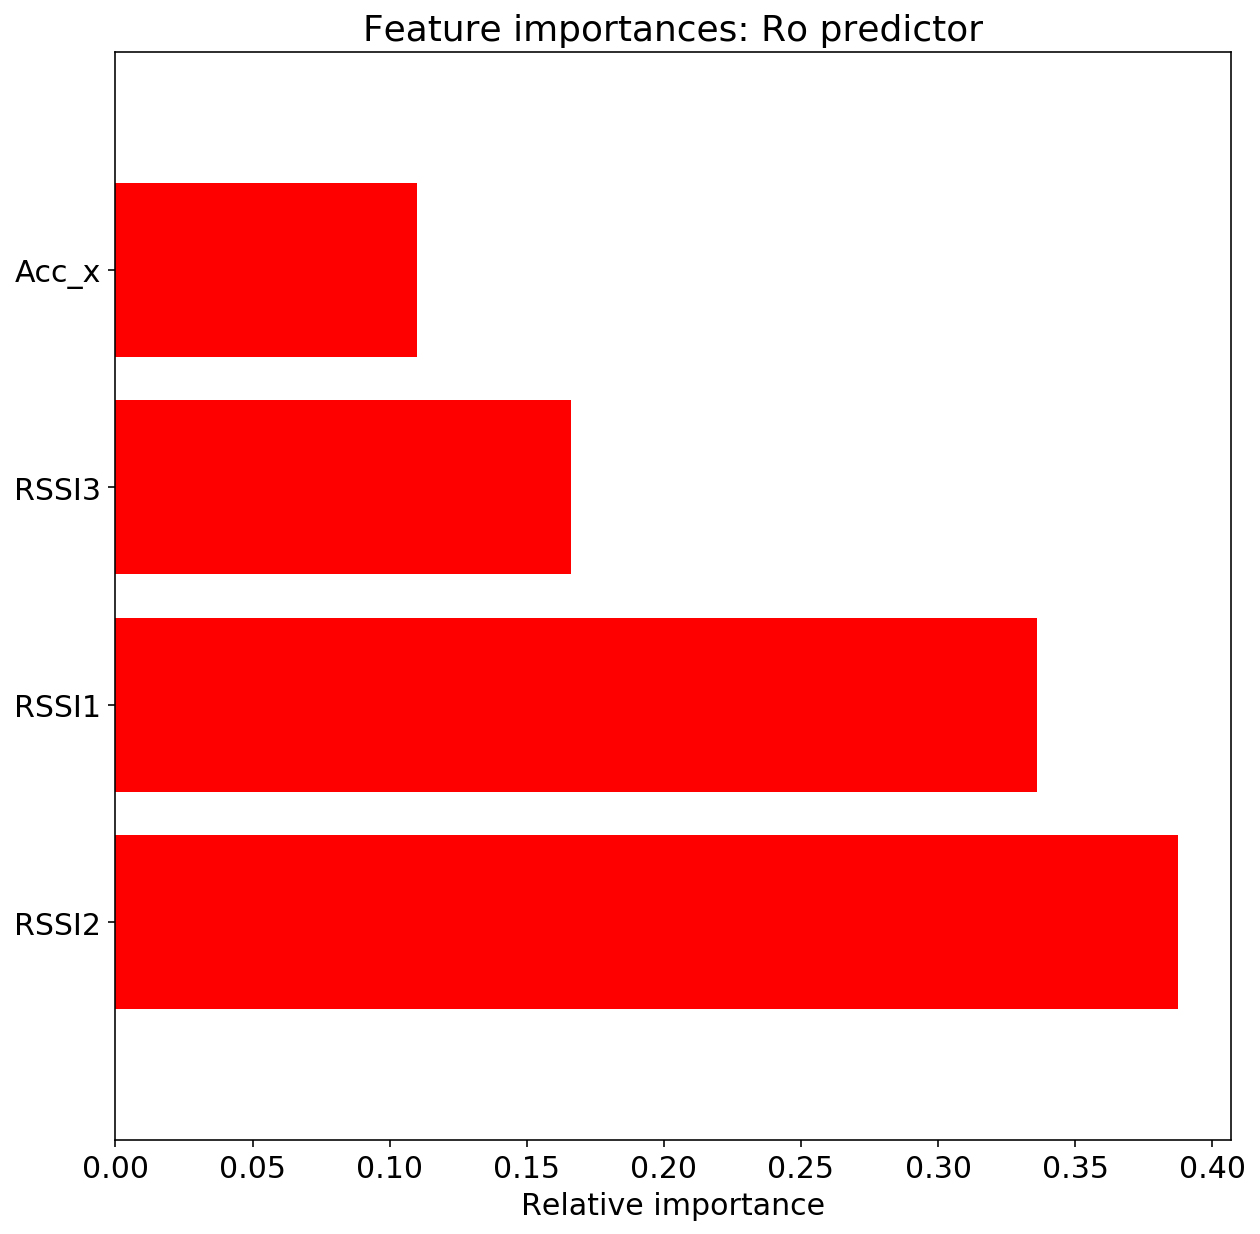

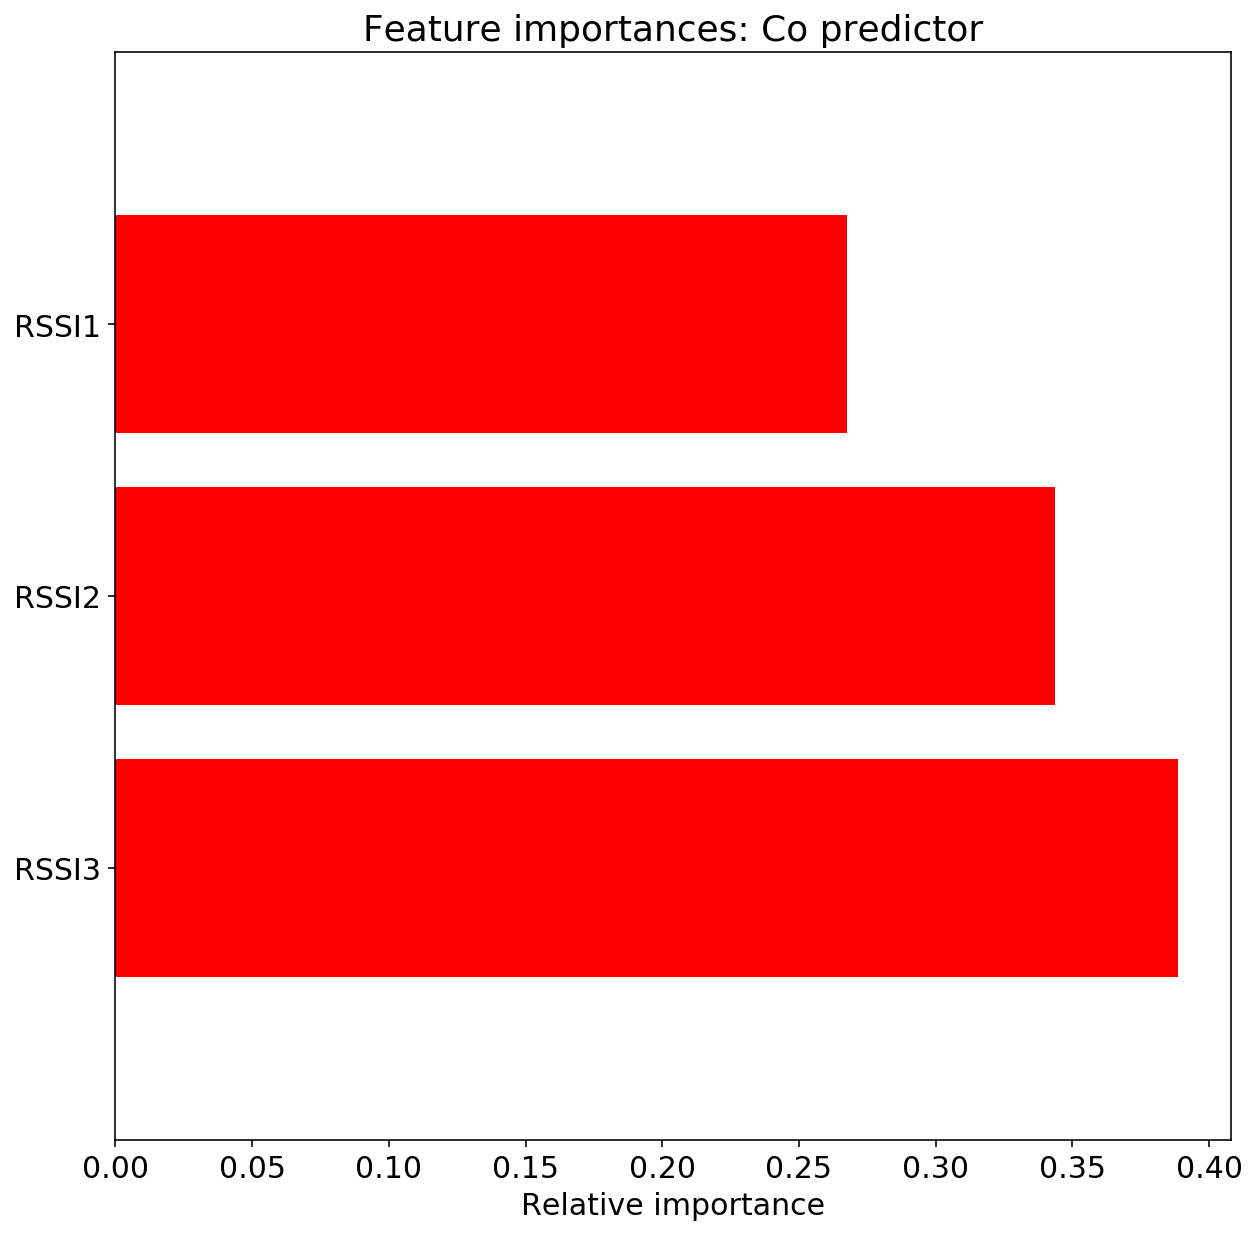

In [10]:
for i, target in enumerate(feature_dict.keys()):
    
    f = open('tree'+str(target)+'.txt', 'w')
    sys.stdout = f
    
    features = feature_dict[target]
    
    X = dfn[features]
    y = dfn[target]
    
    X.astype(int)
    y.astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66, random_state=42)
    
    #clf = tree.DecisionTreeClassifier(max_depth=depth_dict[target], min_samples_split=0.01, min_samples_leaf=0.01, random_state=42)
    clf = tree.DecisionTreeClassifier(max_depth=depth_dict[target], random_state=42)
    clf = clf.fit(X_train, y_train)
    
    tree.export_graphviz(clf, 
                         feature_names=features, 
                         out_file='tree_'+str(target)+'.dot')
    
    importances = clf.feature_importances_
    
    print("%s predictor" % target)
    print("Feature importances")
    print(importances)
    
    indices = np.argsort(importances)[::-1]
    labels = np.array( [x for _,x in sorted(zip(indices.tolist(),features))] )
    fig = plt.figure()
    plt.title("Feature importances: %s predictor" % target)
    plt.barh(range(X_train.shape[1]), importances[indices], color="r", align="center")
    plt.yticks(range(X_train.shape[1]), labels)
    plt.ylim([-1, X_train.shape[1]])
    plt.xlabel("Relative importance")
    plt.show()
    fig.savefig("importance_"+str(target)+".pdf")
    
    pred = clf.predict(X_test)
    score = np.sum( (pred-y_test)==0 )
    score = float(score) / float(y_test.shape[0])
    print("Score on test set:")
    print(score)
    
    oldstdout = sys.stdout
    f = open('tree'+str(target)+'.txt', 'w')
    sys.stdout = f
    target_names = range(1, clf.n_classes_+1)
    get_code(clf, feature_names = features, target_names = target_names)
    f.close()
    sys.stdout = oldstdout